In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report
from google.colab import files

In [ ]:
# === SET RANDOM SEED FOR REPRODUCIBILITY ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# === CONFIG ===
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = "/content/drive/MyDrive/dataset_gambar"
EPOCHS = 25

In [ ]:
# === LOAD DATASETS ===
train_ds = image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    os.path.join(DATA_DIR, "valid"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 7776 files belonging to 42 classes.
Found 1039 files belonging to 42 classes.
Found 1024 files belonging to 42 classes.


In [ ]:
# === DATA AUGMENTATION + PREPROCESSING ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Use MobileNetV3-specific preprocessing
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    image = mobilenet_v3_preprocess(image)
    return image, label

def preprocess_only(image, label):
    image = mobilenet_v3_preprocess(image)
    return image, label

train_ds = train_ds.map(preprocess_and_augment)
val_ds = val_ds.map(preprocess_only)
test_ds = test_ds.map(preprocess_only)

# PREFETCHING
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# === MODEL SETUP ===
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === LEARNING RATE SCHEDULE AND OPTIMIZER ===
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=6000,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === CALLBACKS ===
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# === TRAIN ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0765 - loss: 3.7953

243/243 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.0769 - loss: 3.7932 - val_accuracy: 0.3013 - val_loss: 2.6211
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4690 - loss: 1.9060

243/243 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.4693 - loss: 1.9048 - val_accuracy: 0.4658 - val_loss: 1.8550
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6513 - loss: 1.1481

243/243 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.6514 - loss: 1.1476 - val_accuracy: 0.5765 - val_loss: 1.4557
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7358 - loss: 0.8735

243/243 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.7359 - loss: 0.8733 - val_accuracy: 0.6959 - val_loss: 1.0654
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7773 - loss: 0.7039

243/243 ━━━━━━━━━━━━━━━━━━━━ 745s 3s/step - accuracy: 0.7774 - loss: 0.7037 - val_accuracy: 0.7478 - val_loss: 0.9112
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8066 - loss: 0.6138

243/243 ━━━━━━━━━━━━━━━━━━━━ 835s 3s/step - accuracy: 0.8067 - loss: 0.6135 - val_accuracy: 0.7748 - val_loss: 0.8280
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8391 - loss: 0.4931

243/243 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.8391 - loss: 0.4929 - val_accuracy: 0.7854 - val_loss: 0.7782
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8583 - loss: 0.4259

243/243 ━━━━━━━━━━━━━━━━━━━━ 742s 3s/step - accuracy: 0.8584 - loss: 0.4258 - val_accuracy: 0.8065 - val_loss: 0.7413
Epoch 9/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - accuracy: 0.8733 - loss: 0.3771 - val_accuracy: 0.7979 - val_loss: 0.8076
Epoch 10/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.8834 - loss: 0.3303 - val_accuracy: 0.8133 - val_loss: 0.7734
Epoch 11/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9075 - loss: 0.2680

243/243 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.9075 - loss: 0.2680 - val_accuracy: 0.8325 - val_loss: 0.7190
Epoch 12/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.9196 - loss: 0.2267 - val_accuracy: 0.8114 - val_loss: 0.7376
Epoch 13/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.9182 - loss: 0.2167 - val_accuracy: 0.7921 - val_loss: 0.7958
Epoch 14/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 805s 3s/step - accuracy: 0.9322 - loss: 0.1935 - val_accuracy: 0.8075 - val_loss: 0.7729
Epoch 15/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.9334 - loss: 0.1753 - val_accuracy: 0.8037 - val_loss: 0.8356
Epoch 16/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.9333 - loss: 0.1632 - val_accuracy: 0.8075 - val_loss: 0.7731
Epoch 17/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.9373 - loss: 0.1528 - val_accuracy: 0.8008 - val_loss: 0.8268
Epoch 18/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.9390 - loss: 0.1424 - val_accuracy

In [ ]:
# === EVALUATE ON TEST SET ===
print("\nEvaluating on test set:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# === PREDICTIONS & CLASSIFICATION REPORT ===
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === SAVE FINAL MODEL ===
model.save("final_model.keras")
model = tf.keras.models.load_model("final_model.keras")
files.download("final_model.keras")


Evaluating on test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8482 - loss: 0.7256
Test accuracy: 84.77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 81 variables whereas the saved optimizer has 159 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

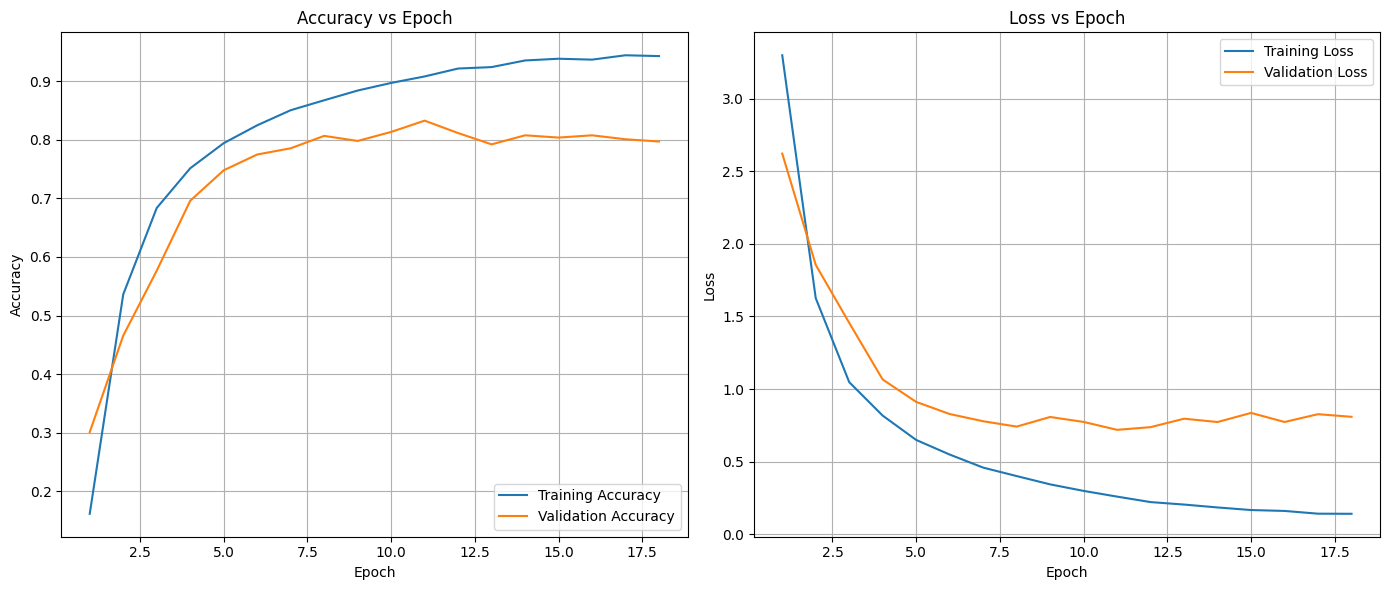

In [ ]:
# === PLOT TRAINING HISTORY ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()